In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from dataset import MNISTDataset
from model import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(hiragana)


In [2]:
dataset = MNISTDataset()
train_images = dataset.images_train
test_images = dataset.images_test
len_test = len(test_images)
len_train = len(train_images)

Training alphabets: 

['Japanese_(hiragana)']
Validation alphabets:

['Japanese_(hiragana)']
===Loading Hiragana Dataset===
Images train : (780, 105, 105, 1)
Labels train : (780, 1)
Images test  : (260, 105, 105, 1)
Labels test  : (0,)
Unique label : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]


In [3]:
right, left, label = dataset.get_siamese_batch(100)

In [4]:
np.unique(label, return_counts=True)

(array([0, 1]), array([56, 44]))

In [5]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,0], cmap='gray')
        ax.axis('off')
    plt.show()

## Create the siamese net feature extraction model

In [6]:
img_placeholder = tf.placeholder(tf.float32, [None, 105, 105, 1], name='img')
net = mnist_model(img_placeholder, reuse=False)

W1101 20:06:45.607989 140611688003328 deprecation_wrapper.py:119] From /home/felliperego12/.jupyter/Notebooks/siamese-network/model.py:13: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1101 20:06:45.958626 140611688003328 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


## Restore from checkpoint and calc the features from all of train data

In [18]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/x512-5000/model.ckpt")
    
    train_feat = sess.run(net, feed_dict={img_placeholder:test_images})                

## Searching for similar test images from trainset based on siamese feature

In [21]:
#generate new random test image
idx = np.random.randint(0, len_test)
im = test_images[idx]

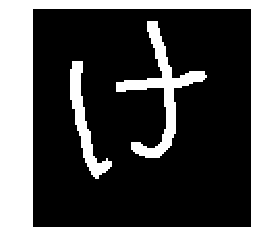

Base image id: 80


In [22]:
#show the test image
show_image(idx, test_images)
print("Base image id:", idx)

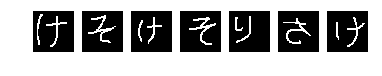

Ranked id's list: [ 80  29  84  27 134 139  82]


In [23]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/x512-5000/model.ckpt")
    search_feat = sess.run(net, feed_dict={img_placeholder:[im]})
    
#calculate the cosine similarity and sort
dist = cdist(train_feat, search_feat, 'cosine')
rank = np.argsort(dist.ravel())

#show the top n similar image from train data
n = 7
show_image(rank[:n], train_images)
print("Ranked id's list:", rank[:n])